In [84]:
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import sys
%matplotlib inline
sns.set()

In [85]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')
x = data['X']
y = (np.zeros(50000)).reshape(5000, 10)
theta1 = np.array(weights['Theta1'])
theta2 = np.array(weights['Theta2'])

In [86]:
for number in range(0, 10):
    if number == 0:
        y[0:500, 9:] = 1
    else:
        y[number * 500:(number + 1) * 500, number - 1:number] = 1

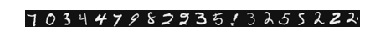

In [87]:
sample = np.random.choice(x.shape[0], 20)
plt.imshow(x[sample, :].reshape(-1, 20).T, cmap='gray')
plt.axis('off');

In [182]:
def sigmoidFunction (z):
    return 1 / (1 + np.exp(-z))

In [183]:
def hypothesisFunction (x, theta1, theta2):
    a1 = np.c_[np.ones((data['X'].shape[0], 1)), x]
    z2 = np.dot(a1, theta1.T)
    
    a2 = np.c_[np.ones((data['X'].shape[0], 1)), sigmoidFunction(z2)]
    z3 = np.dot(a2, theta2.T)
    
    a3 = sigmoidFunction(z3)
    return a3

In [184]:
def costFunction (y, hypothesisFunction):
    m = y.shape[0]
    j = (1 / m) * (np.log(hypothesisFunction).T.dot(-y) - np.log(1 - hypothesisFunction).T.dot(1 - y))
    return j

In [185]:
c = costFunction (y, hypothesisFunction (x, theta1, theta2))
costs = []
for number in range(10):
    costs.append(c[number, number])
mainCosts = np.array(costs)

In [188]:
def regularizedCostFunction (costs, theta1, theta2, λ):
    m = y.shape[0]
    costs += ((λ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))))
    return costs

In [194]:
def sigmoidGradient (z):
    return sigmoidFunction(z) * (1 - sigmoidFunction(z))